In [2]:
from scipy.stats import randint, uniform, loguniform
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import openml
from scipy.stats import gaussian_kde
import warnings
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, make_scorer
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
warnings.filterwarnings('ignore')
RANDOM_STATE = 42


In [3]:
experiment_results = pd.read_csv("experiment_results.csv")

## Below is the code for executing the experiment, by default you can skip this part, because the file containg dataframe with results is provided 

# Notation Remark
Tunability is the difference between the score on the optimal hyperparameter  and the best score on given dataset. 


Score difference is the difference between the score on optimal hyperparameter and every other score on given dataset. 


The score difference was not included in paper, but because of the nature on tunability, there is only just few points, which is harder to visualize, especially showing distributions

In [ ]:
def get_datasets():
    # for loading datasets from OpenML, and mapping target labels to 0 and 1
    datasets = {}

    mapping = {'1': 0, '2': 1}  # Using 1.0/2.0 as OpenML often returns float for numerical categories
    dataset_1 = openml.datasets.get_dataset(1494)
    X_1, y_1, _, _= dataset_1.get_data(
        dataset_format="dataframe", 
        target=dataset_1.default_target_attribute
    )
    y_1 = y_1.replace(mapping)
    df_1 = pd.concat([X_1, y_1], axis=1)
    df_1.name = dataset_1.name 
    datasets[df_1.name] = df_1

    dataset_2 = openml.datasets.get_dataset(1489)
    X_2, y_2, _, _ = dataset_2.get_data(
        dataset_format="dataframe",  
        target=dataset_2.default_target_attribute
    )
    y_2 = y_2.replace(mapping)
    df_2 = pd.concat([X_2, y_2], axis=1)
    df_2.name = dataset_2.name 
    datasets[df_2.name] = df_2


    dataset_3 = openml.datasets.get_dataset(1487)
    X_3, y_3, _, _ = dataset_3.get_data(
        dataset_format="dataframe", 
        target=dataset_3.default_target_attribute
    )
    y_3 = y_3.replace(mapping)
    df_3 = pd.concat([X_3, y_3], axis=1)
    df_3.name = dataset_3.name 
    datasets[df_3.name] = df_3


    dataset_4 = openml.datasets.get_dataset(1471)
    X_4, y_4, _, _ = dataset_4.get_data(
        dataset_format="dataframe", 
        target=dataset_4.default_target_attribute
    )
    y_4 = y_4.replace(mapping)
    df_4 = pd.concat([X_4, y_4], axis=1)
    df_4.name = dataset_4.name 
    datasets[df_4.name] = df_4
    
    return datasets

In [ ]:
def get_models_and_spaces():
    # defining models and hyperparameter search spaces
    models = {
        "RandomForest": Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
        ]),
        "XGBoost": Pipeline([
            ('scaler', StandardScaler()),
            ('xgb', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
        ]),
        "SGDClassifier": Pipeline([
            ('scaler', StandardScaler()),
            ('sgd', SGDClassifier(loss='log_loss', random_state=RANDOM_STATE))
        ])
    }
    spaces_random= {
        "RandomForest": {
                'rf__n_estimators': randint(2, 1000),    
                'rf__max_depth': randint(2, 32),
                'rf__min_samples_split': randint(2, 32)
    },
        
        
        "XGBoost": {
                'xgb__n_estimators': randint(2, 2000),    
                'xgb__max_depth': randint(1, 15),
                'xgb__learning_rate': loguniform(0.001, 1.0),
                'xgb__subsample': uniform(0.1, 0.9)    
    },
        
    
        "SGDClassifier": {
                'sgd__alpha': loguniform(1e-6, 1e-1),
                'sgd__penalty': ['l2', 'l1', 'elasticnet'],
                'sgd__l1_ratio': uniform(loc=0.0, scale=1.0)                     
                                       }
    }
    spaces_bayes= {
        "RandomForest": {
                'rf__n_estimators': Integer(2, 1000),
                'rf__max_depth': Integer(2, 32),
                'rf__min_samples_split': Integer(2, 32)
                              },
        "XGBoost": {
                'xgb__n_estimators': Integer(2, 2000),
                'xgb__max_depth': Integer(1, 15),
                'xgb__learning_rate': Real(0.001, 1.0, 'log-uniform'),
                'xgb__subsample': Real(0.1, 1.0, 'uniform')
                       },
        "SGDClassifier": {
                'sgd__alpha': Real(1e-6, 1e-1, 'log-uniform'),
                'sgd__penalty': Categorical(['l2', 'l1', 'elasticnet']),
                'sgd__l1_ratio': Real(0.0, 1.0, 'uniform')
                           }
    }
    return models, spaces_bayes, spaces_random

In [ ]:
CV_SPLITS = 2
N_ITER_TUNING = 40
def run_experiment():
    # function for running the full experiment, consists of data loading, subsetting, model tuning, and results collection
    DATA_FRACTIONS = [0.25, 0.5, 0.75, 1.0]
    datasets = get_datasets()
    models, spaces_bayes, spaces_random = get_models_and_spaces()
    all_results_list = [] 
    scorer = make_scorer(roc_auc_score, needs_proba=True) 
    for d_name, df in datasets.items():
        target_name = "Class" 
        y = df[target_name]
        X = df.drop(columns=[target_name])
        print(f"\n--- Processing dataset: {d_name} (Full shape: {X.shape}")
        for fraction in DATA_FRACTIONS:
            if fraction == 1.00:
                X_subset = X
                y_subset = y
            else:
                X_subset, _, y_subset, _ = train_test_split(
                    X, y, 
                    train_size=fraction, 
                    random_state=RANDOM_STATE, 
                    stratify=y
                )
            
            print(f"   -- Data fraction: {fraction*100}% (Subset shape: {X_subset.shape}) --")
            for m_name in models.keys():
                print(f"     -> Model: {m_name}")
                cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

                tuners = {
                    "RandomSearch": RandomizedSearchCV(
                        models[m_name], 
                        spaces_random[m_name],
                        n_iter=N_ITER_TUNING, scoring=scorer,
                        cv = cv, 
                        random_state=RANDOM_STATE, n_jobs=-1,
                    ),
                    "BayesSearch": BayesSearchCV(
                        models[m_name], 
                        spaces_bayes[m_name],
                        n_iter=N_ITER_TUNING, scoring=scorer, 
                        random_state=RANDOM_STATE, n_jobs=-1,
                        cv = cv,
                        optimizer_kwargs={'base_estimator': 'GP'}
                    )
                }

                for t_name, tuner in tuners.items():
                    print(f"       - Tuning method: {t_name}")
                    try:
                        tuner.fit(X_subset, y_subset)
                        
                        results_df = pd.DataFrame(tuner.cv_results_)
                        param_cols = [col for col in results_df.columns if col.startswith('param_')]
                        
                        keep_cols = param_cols + ['mean_test_score']
                        run_df = results_df[keep_cols].copy()
                        
                        run_df.columns = [c.replace('param_', '') for c in run_df.columns]
                        run_df.rename(columns={'mean_test_score': 'AUC'}, inplace=True)
                        run_df['dataset'] = d_name
                        run_df['data_fraction'] = fraction
                        run_df['model'] = m_name
                        run_df['tuning_method'] = t_name
                        run_df['iteration'] = run_df.index + 1
                        all_results_list.append(run_df)
                          
                    except Exception as e:
                        print(f"       - Error while tuning {t_name} on {d_name} (fraction {fraction}) with {m_name}: {e}")

    
    if not all_results_list:
        print("Warning: No results were collected.")
        return pd.DataFrame()
        
    final_results_df = pd.concat(all_results_list, ignore_index=True)
    
    # for changing the order of columns
    meta_cols = ['dataset', 'data_fraction', 'model', 'tuning_method', 'iteration', 'AUC']
    param_cols = [col for col in final_results_df.columns if col not in meta_cols]
    
    return final_results_df[meta_cols + param_cols]

In [7]:
experiment4 = run_experiment()

NameError: name 'run_experiment' is not defined

# The visualization part starts here

In [ ]:
def plot_convergence_matplotlib(df: pd.DataFrame):
    # function for plotting convergence results using matplotlib
    plt.style.use('ggplot')
    df['best_score_so_far'] = df.groupby(['dataset', 'data_fraction', 'model', 'tuning_method'])['AUC'].cummax()
    agg_df = df.groupby(['data_fraction', 'model', 'tuning_method', 'iteration'])['best_score_so_far'].agg(['mean', 'std']).reset_index()
    data_fractions = sorted(agg_df['data_fraction'].unique())
    models = sorted(agg_df['model'].unique())
    fig, axes = plt.subplots(len(data_fractions), len(models), 
                             figsize=(6 * len(models), 5 * len(data_fractions)), 
                             sharex=True, sharey=False) 
    
    # Handle the case where the subplot array might be 1D or a single axis object
    if len(data_fractions) == 1 and len(models) == 1:
        axes = np.array([[axes]])
    elif len(data_fractions) == 1:
        axes = np.expand_dims(axes, axis=0)
    elif len(models) == 1:
        axes = np.expand_dims(axes, axis=1)

    colors = {'RandomSearch': 'darkorange', 'BayesSearch': 'navy'}
    for row, fraction in enumerate(data_fractions):
        for col, model in enumerate(models):
            ax = axes[row, col]
            plot_df = agg_df[(agg_df['data_fraction'] == fraction) & (agg_df['model'] == model)]
            for method, color in colors.items():
                group = plot_df[plot_df['tuning_method'] == method]
                if not group.empty:
                    label = f"{method}"
                    ax.plot(group['iteration'], group['mean'], 
                            label=label, 
                            color=color, 
                            lw=2)
            
            ax.set_title(f'{model} ({fraction*100:.0f}% data)', fontsize=12)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)

            if row == len(data_fractions) - 1:
                ax.set_xlabel('Iteration Number', fontsize=11)
            if col == 0:
                ax.set_ylabel('Best Averaged AUC', fontsize=11)
                
            if row == 0 and col == len(models) - 1:
                handles, labels = ax.get_legend_handles_labels()
                fig.legend(handles, labels, loc='upper right', title='Tuning Method', bbox_to_anchor=(1.02, 0.95))


    fig.suptitle('Tuning Method Convergence by Model and Data Fraction (Best AUC Score in Iteration)', fontsize=16, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [ ]:
def find_rows_with_params(df, defaults_dict):
    # This function filters the DataFrame to find rows matching the default parameters for each model
    matched_frames = []
    for model_name, model_data in defaults_dict.items():
        params = model_data.get('params', {})
        current_mask = (df['model'] == model_name)
        for param_col, param_value in params.items():
            if param_col in df.columns:
                current_mask = current_mask & (df[param_col] == param_value)
            else:
                print(f"Warning: Column '{param_col}' not found in DataFrame for model '{model_name}'")
                
        matched_frames.append(df[current_mask])

    if matched_frames:
        result = pd.concat(matched_frames)
        return result
    else:
        return pd.DataFrame(columns=df.columns)

In [ ]:
def find_new_optimal_defaults(df: pd.DataFrame):
    # we only consider RandomSearch results for finding new defaults
    # because bayesian methods test different hyperparameter configurations, unlike random search which samples from a fixed distribution if keeping the same random state
    # 
    df = df[df['tuning_method'] == 'RandomSearch'].copy()
    meta_cols = ['dataset', 'data_fraction', 'model', 'tuning_method', 'iteration', 'AUC']
    param_cols = [col for col in df.columns if col not in meta_cols]
    df['params_key'] = df.apply(
        lambda row: frozenset(
            (col, row[col]) for col in param_cols if pd.notna(row[col])
        ), 
        axis=1
    )
    
    avg_performance = df.groupby(['model', 'params_key'])['AUC'].mean().reset_index()
    new_defaults = {}
    for model_name in df['model'].unique():
        model_avg_perf = avg_performance[avg_performance['model'] == model_name]
        if model_avg_perf.empty:
            print(f"No data for model: {model_name}")
            continue
        best_config_row = model_avg_perf.loc[model_avg_perf['AUC'].idxmax()]
        best_params_dict = dict(best_config_row['params_key']) 
        new_defaults[model_name] = {
            'params': best_params_dict,
            'avg_score': best_config_row['AUC']
        }
        print(f"New Default for '{model_name}': {new_defaults[model_name]['params']} (Avg. AUC: {new_defaults[model_name]['avg_score']:.4f})")
        
    return new_defaults

def score_diff_results(df: pd.DataFrame):
    # for computing score differences against new defaults
    df = df.copy() 
    new_defaults = find_new_optimal_defaults(df)
    def get_default_score(row):
        return new_defaults.get(row['model'], {}).get('avg_score', np.nan)
    df['default_score'] = df.apply(get_default_score, axis=1)
    df['score_difference'] = df['default_score'] - df['AUC']

    return df, new_defaults


def score_diff_distribution(df: pd):
    # for plotting score difference distributions
    df_copy = df.copy() 
    fig, ax = plt.subplots(figsize=(15, 7))
    colors = {model: plt.cm.get_cmap('Set1')(i) for i, model in enumerate(df_copy['model'].unique())} 
    for model_name, color in colors.items():
        data = df_copy[df_copy['model'] == model_name]['score_difference'].dropna()
        
        if len(data) > 1:
            kde = gaussian_kde(data)
            x_min = df_copy['score_difference'].min() if not df_copy['score_difference'].empty else -0.1
            x_max = df_copy['score_difference'].max() if not df_copy['score_difference'].empty else 0.1
            x_range = np.linspace(x_min - 0.05, x_max + 0.05, 500)
            density = kde(x_range)
            
            ax.plot(x_range, density, label=model_name, color=color, lw=2)
            ax.fill_between(x_range, density, color=color, alpha=0.3)

    ax.set_title('Distribution of score differences', fontsize=16)
    ax.set_xlabel('Difference of score on optimal parameter and current run score', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.axvline(0, color='red', linestyle='--', label='No Difference (i.e., this configuration is as good as the global default)')
    ax.legend(title='Model')
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def analyze_sampling_bias_matplotlib(df: pd.DataFrame):
    # for plotting score difference distributions by sampling method
    models = sorted(df['model'].unique())
    data_fractions = sorted(df['data_fraction'].unique())
    fig, axes = plt.subplots(len(data_fractions), len(models), 
                                 figsize=(4 * len(models), 4 * len(data_fractions)), 
                                 sharex=True, sharey=True)
    
    if len(data_fractions) == 1 and len(models) == 1:
        axes = np.array([[axes]])
    elif len(data_fractions) == 1:
        axes = np.expand_dims(axes, axis=0)
    elif len(models) == 1:
        axes = np.expand_dims(axes, axis=1)
    
    global_min = df['score_difference'].min() if not df['score_difference'].empty else -0.1
    global_max = df['score_difference'].max() if not df['score_difference'].empty else 0.1
    x_range = np.linspace(global_min - 0.05, global_max + 0.05, 500)
    linestyles = {'RandomSearch': '-', 'BayesSearch': '--'}

    for row, fraction in enumerate(data_fractions):
        for col, model_name in enumerate(models):
            ax = axes[row, col]
            
            for tuning_method, linestyle in linestyles.items():
                data = df[
                    (df['model'] == model_name) & 
                    (df['tuning_method'] == tuning_method) &
                    (df['data_fraction'] == fraction)
                ]['score_difference'].dropna()
                
                if len(data) > 1:
                    kde = gaussian_kde(data)
                    density = kde(x_range)
                    ax.plot(x_range, density, linestyle=linestyle, label=tuning_method)
                    ax.fill_between(x_range, density, alpha=0.2)
            
            ax.set_title(f'{model_name} ({fraction*100:.0f}%)', fontsize=10)
            ax.axvline(0, color='red', linestyle=':', alpha=0.7)
            ax.grid(True, linestyle='--', alpha=0.5)
            
            if col == 0:
                ax.set_ylabel('Density', fontsize=10)
            
            if row == 0 and col == len(models) - 1:
                 handles, labels = ax.get_legend_handles_labels()
                 fig.legend(handles, labels, loc='upper right', title='Tuning Method', bbox_to_anchor=(1.02, 0.95))
                 
            if row == len(data_fractions) - 1:
                ax.set_xlabel('Score Difference', fontsize=10)


    fig.suptitle('Comparison of tunability distributions by sampling method', fontsize=14, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [ ]:
def visualize_boxplot(
    df: pd.DataFrame,
    group_col: str = 'model',
    score_col: str = 'score_difference',
    spread_factor: float = 0.4
    ) -> None:
    # for plotting boxplots with overlaid scatter points
    grouped_data = df.groupby(group_col)[score_col].apply(list)
    y_max = df[score_col].max() * 1.2
    box_styles = dict(
        patch_artist=True, boxprops={'facecolor': 'white', 'edgecolor': 'black'},
        medianprops={'color': 'black'}, whiskerprops={'color': 'black'}, 
        capprops={'color': 'black'}, showfliers=False
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.boxplot(grouped_data.values, labels=grouped_data.index, **box_styles)
    
    for i, scores in enumerate(grouped_data.values):
        x_positions = (i + 1) + (np.random.rand(len(scores)) - 0.5) * spread_factor
        plt.scatter(x_positions, scores, color='black', s=25, alpha=0.8)

    plt.title(f'Boxplots of the {score_col} of algorithms')
    plt.ylabel(f' {score_col}')
    plt.ylim(0.0, y_max) 
    plt.yticks(np.around(np.linspace(0.0, y_max, 10), decimals=3)) 
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    plt.show()

In [ ]:
def tunability_no_fraction_results(df, new_defaults): 
    # for computing tunability without considering data fraction
    dataset_best_scores = df.groupby(['model', 'dataset'])['AUC'].max().reset_index()
    dataset_best_scores = dataset_best_scores.rename(columns={'AUC': 'dataset_best_score'})
    defaults_results = find_rows_with_params(df, new_defaults)
    defaults_scores = defaults_results[['model', 'dataset', 'AUC', 'data_fraction', 'tuning_method']].copy()
    defaults_scores = defaults_scores.rename(columns={'AUC': 'default_score'})
    tunability_scores_no_fraction = pd.merge(dataset_best_scores, defaults_scores, on=['model', 'dataset'], how='left')
    tunability_scores_no_fraction['tunability'] = tunability_scores_no_fraction['dataset_best_score'] - tunability_scores_no_fraction['default_score']

    return tunability_scores_no_fraction


In [46]:
experiment_results_no_fractions = experiment_results[experiment_results['data_fraction'] == 1.0].copy()

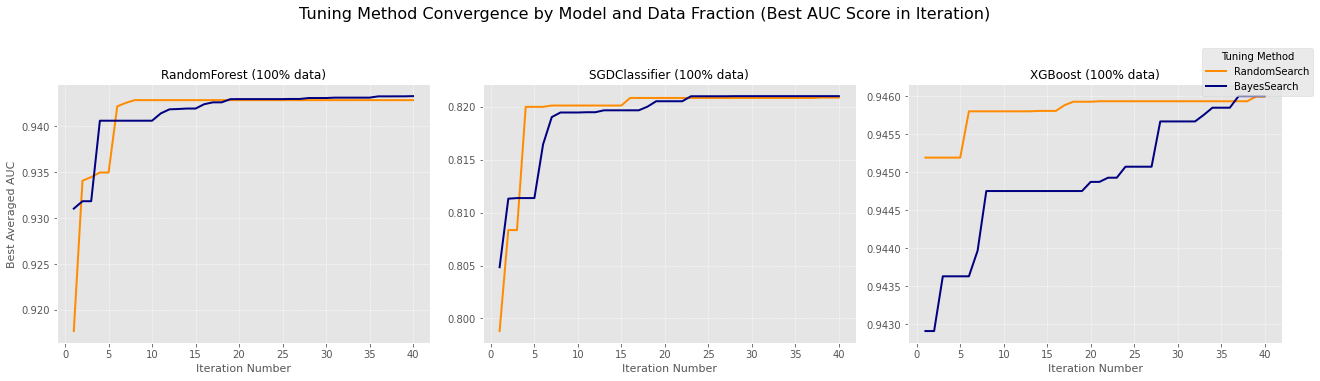

In [47]:
plot_convergence_matplotlib(experiment_results_no_fractions.copy())


In [48]:
score_diff_no_fractions, new_defaults_no_fractions = score_diff_results(experiment_results_no_fractions.copy())
tunability_results_no_fractions = tunability_no_fraction_results(score_diff_no_fractions.copy(), new_defaults_no_fractions)

New Default for 'RandomForest': {'rf__n_estimators': 873.0, 'rf__max_depth': 22.0, 'rf__min_samples_split': 5.0} (Avg. AUC: 0.9422)
New Default for 'XGBoost': {'xgb__learning_rate': 0.0132929189431621, 'xgb__subsample': 0.7587945476302645, 'xgb__max_depth': 13.0, 'xgb__n_estimators': 1296.0} (Avg. AUC: 0.9452)
New Default for 'SGDClassifier': {'sgd__l1_ratio': 0.2747217929900641, 'sgd__penalty': 'elasticnet', 'sgd__alpha': 0.0009046673956058} (Avg. AUC: 0.8191)


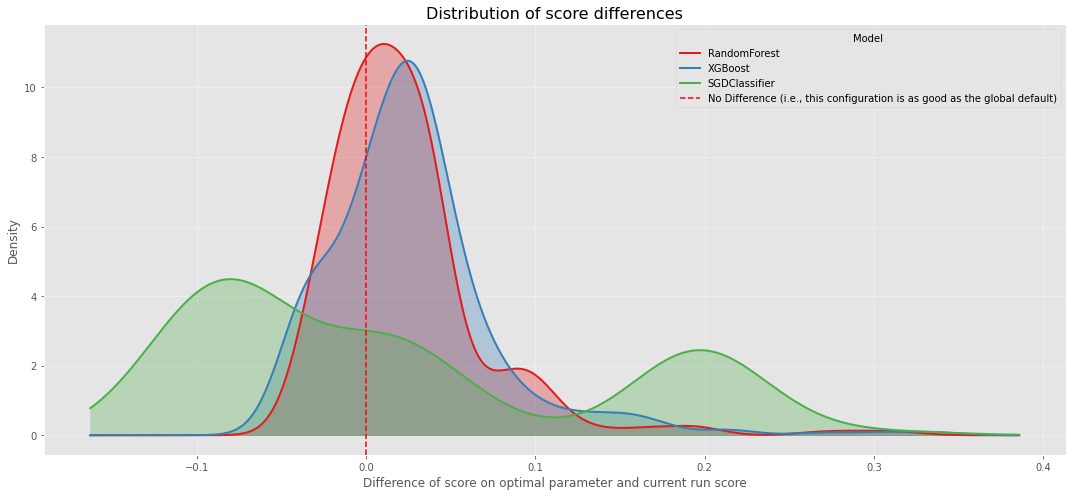

In [49]:
score_diff_distribution(score_diff_no_fractions)

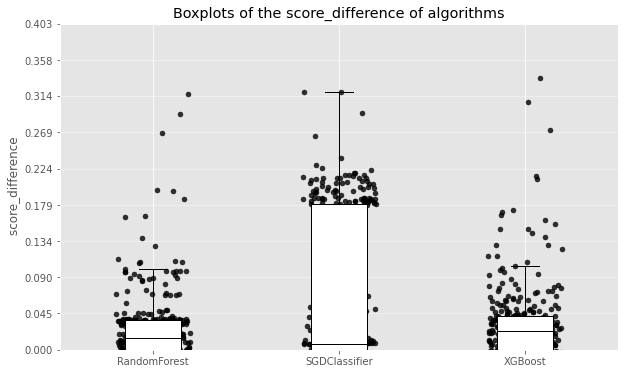

In [50]:
visualize_boxplot(score_diff_no_fractions)

THAT DATAFRAME ABOVE SHOWS TUNABILITY THAT WAS PRESENTED IN THE PAPER.
 WHICH IS THE DIFFERENCE BETWEEN BEST SCORE FOR THAT DATASET AND DEFAULT SCORE.

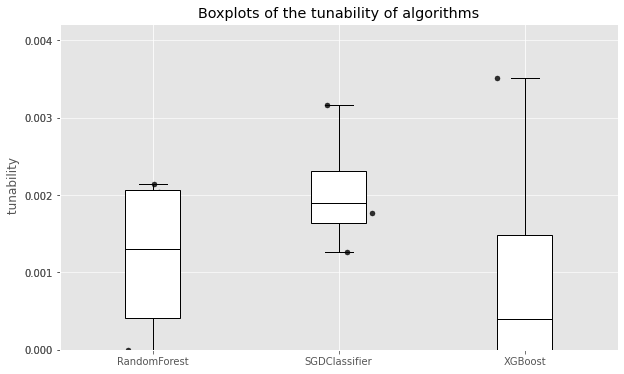

In [51]:
visualize_boxplot(tunability_results_no_fractions, score_col='tunability')

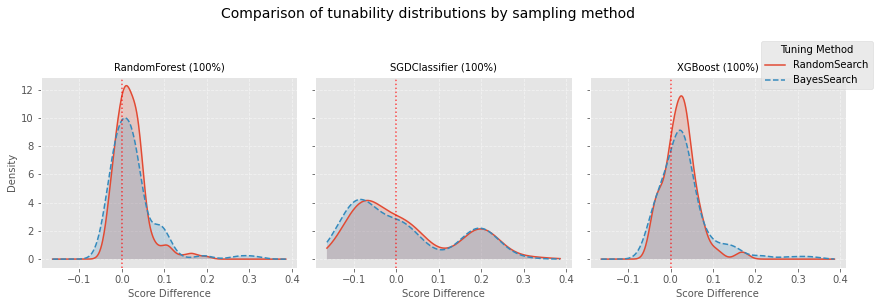

In [52]:
analyze_sampling_bias_matplotlib(score_diff_no_fractions)

# ANALYSIS OF DATA FRACTION 

In [ ]:
def score_diff_distribution_by_data_fraction(df: pd.DataFrame):
    # for plotting score difference distributions by data fraction
    data_fractions = sorted(df['data_fraction'].unique())
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14), sharex=True, sharey=False)
    axes = axes.flatten()
    models = df['model'].unique()
    colors = {model: plt.cm.get_cmap('Set1')(i) for i, model in enumerate(models)}
    # Calculate global min/max for the x-axis to standardize the range if needed
    x_min_global = df['score_difference'].min() if not df['score_difference'].empty else -0.1
    x_max_global = df['score_difference'].max() if not df['score_difference'].empty else 0.1
    x_range_global = np.linspace(x_min_global - 0.05, x_max_global + 0.05, 500)

    for i, fraction in enumerate(data_fractions):
        ax = axes[i]
        df_fraction = df[df['data_fraction'] == fraction]
        for model_name, color in colors.items():
            data = df_fraction[df_fraction['model'] == model_name]['score_difference'].dropna()
            
            if len(data) > 1:
                kde = gaussian_kde(data)
                density = kde(x_range_global)
                ax.plot(x_range_global, density, label=model_name, color=color, lw=2)
                ax.fill_between(x_range_global, density, color=color, alpha=0.3)

        ax.set_title(f'Data Fraction: {fraction}', fontsize=14)
        ax.set_xlabel('Difference of score on optimal parameter and current run score', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.axvline(0, color='red', linestyle='--', label='No Difference')
        ax.legend(title='Model', loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)

    fig.suptitle('Distribution of score differences by data fraction', fontsize=20, y=1.02)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def tunability_boxplot_fractions(
    df: pd.DataFrame, 
    group_col: str = 'model', 
    score_col: str = 'tunability', 
    data_fraction_col: str = 'data_fraction', 
    spread_factor: float = 0.4
) -> None:
    # for plotting boxplots of tunability by data fraction
    fractions = [0.25, 0.5, 0.75, 1.0]
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
    global_y_max = df[score_col].max() * 1.2
    y_ticks = np.around(np.linspace(0.0, global_y_max, 10), 3)
    box_styles = dict(patch_artist=True, boxprops={'facecolor': 'white', 'edgecolor': 'black'}, 
                      medianprops={'color': 'black'}, showfliers=False)
    
    for i, (ax, frac) in enumerate(zip(axes.flatten(), fractions)):
        grouped_data = df[df[data_fraction_col] == frac].groupby(group_col)[score_col].apply(list)
        if not grouped_data.empty:
            ax.boxplot(grouped_data.values, labels=grouped_data.index, **box_styles)         
            for j, scores in enumerate(grouped_data.values):
                ax.scatter((j + 1) + (np.random.rand(len(scores)) - 0.5) * spread_factor, 
                           scores, color='black', s=25, alpha=0.8, zorder=3)
        
        ax.set_title(f'Data Fraction: {frac}', fontsize=14)
        ax.set_ylim(0.0, global_y_max)
        ax.set_yticks(y_ticks)
        ax.grid(axis='y', linestyle='-', alpha=0.5)
        
        if i % 2 == 0: ax.set_ylabel(f'{score_col}', fontsize=12)
        if i >= 2: ax.set_xlabel(group_col, fontsize=12)

    fig.suptitle(f'Boxplots of {score_col} algorithms by data fraction', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
def tunability_fractions_results(df, new_defaults):
    # for computing tunability considering data fraction
    df = df.copy()
    dataset_best_scores = df.groupby(['model', 'dataset'])['AUC'].max().reset_index()
    dataset_best_scores = dataset_best_scores.rename(columns={'AUC': 'dataset_best_score'})
    defaults_results = find_rows_with_params(df, new_defaults)
    defaults_scores = defaults_results[['model', 'dataset', 'AUC', 'data_fraction', 'tuning_method']].copy()
    defaults_scores = defaults_scores.rename(columns={'AUC': 'default_score'})
    tunability_results_fractions = pd.merge(dataset_best_scores, defaults_scores, on=['model', 'dataset'], how='left')
    tunability_results_fractions['tunability'] = tunability_results_fractions['dataset_best_score'] - tunability_results_fractions['default_score']

    return tunability_results_fractions


In [56]:
score_diff_fractions, new_defaults_fractions = score_diff_results(experiment_results.copy())
tunability_results_fractions = tunability_fractions_results(score_diff_fractions.copy(), new_defaults_fractions.copy())

New Default for 'RandomForest': {'rf__min_samples_split': 3.0, 'rf__n_estimators': 345.0, 'rf__max_depth': 22.0} (Avg. AUC: 0.9232)
New Default for 'XGBoost': {'xgb__learning_rate': 0.0132929189431621, 'xgb__subsample': 0.7587945476302645, 'xgb__max_depth': 13.0, 'xgb__n_estimators': 1296.0} (Avg. AUC: 0.9275)
New Default for 'SGDClassifier': {'sgd__penalty': 'l2', 'sgd__alpha': 0.0071587286315001, 'sgd__l1_ratio': 0.4937955963643907} (Avg. AUC: 0.8201)


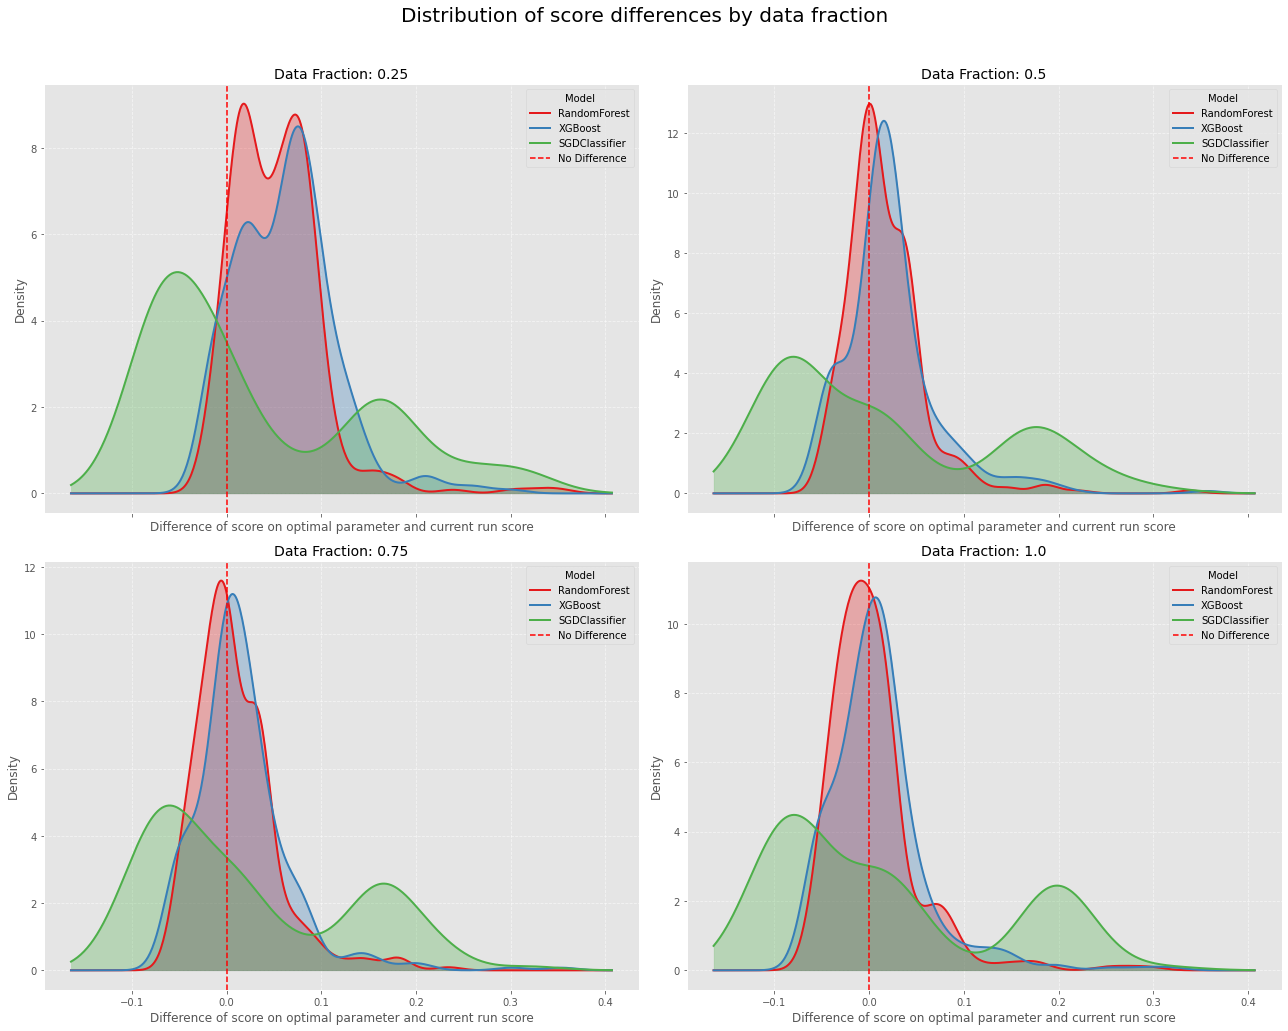

In [57]:
score_diff_distribution_by_data_fraction(score_diff_fractions)

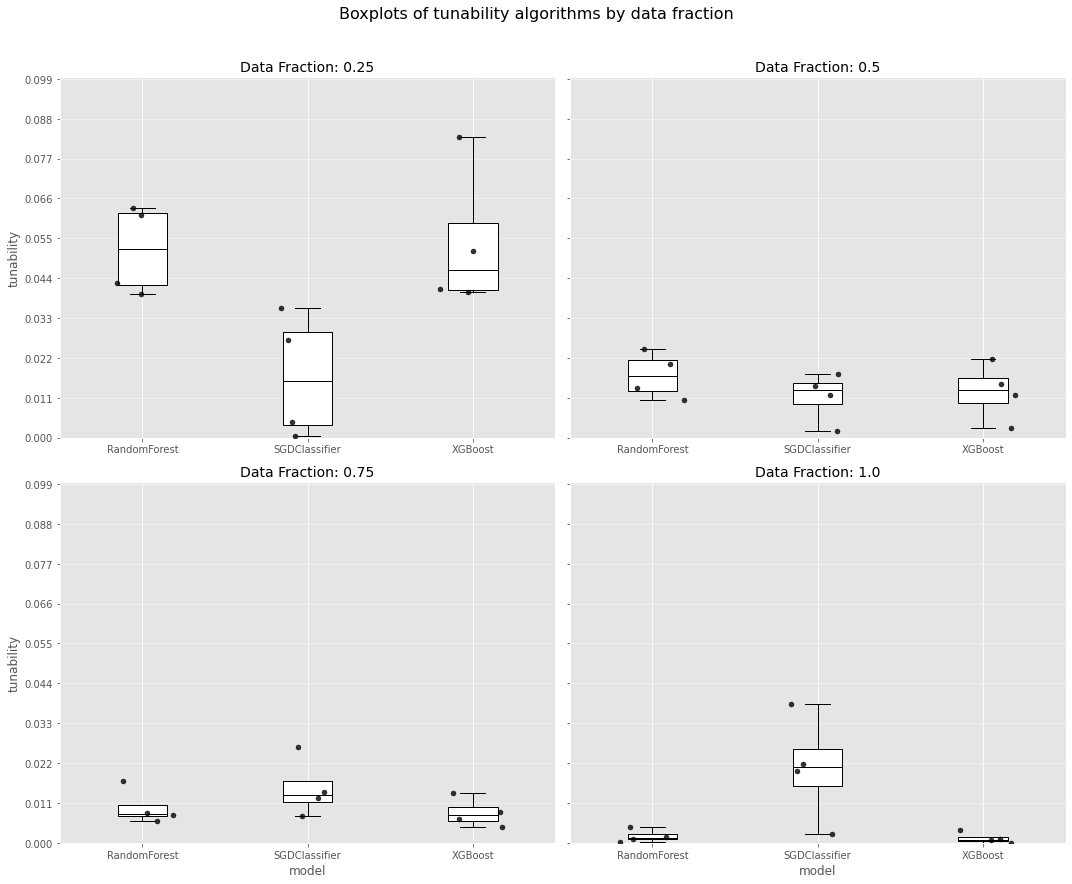

In [58]:
tunability_boxplot_fractions(tunability_results_fractions)